In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42871")
client

<Client: 'tcp://127.0.0.1:42871' processes=8 threads=32, memory=187.53 GiB>

In [2]:
client.restart()

Connection method: Direct,
Dashboard: http://127.0.0.1:8787/status,
Comm: tcp://127.0.0.1:41321,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: 7 hours ago,Total memory: 0 B


In [2]:
import numpy as np
import qgutils
import xarray as xr
import zarr
import shutil
import pickle
from joblib import dump
from sklearn.ensemble import RandomForestRegressor as RFregressor
from rechunker import rechunk
import dask.array as dsar
import os.path as op
import scipy.sparse as spar
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/bettik/uchidat/qg-ML/'

In [4]:
U     = .1
T     = 5e5    # seconds
tau0  = .0001
dt    = 5e-2
Rd    = 5e4   # Rossby radius (50km)
Re4   = 4e3
# f0 = 8e-5
beta  = .5
N     = 1024   # Number of horizontal grids
L0    = 80
H     = 5e3
dx    = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny  = 360
Rom   = .025
Ekb   = .002*2
ntime = int(62.2*5)+1

percent = 20
nmemb = 100

ncoars = 4
DX = dx * ncoars

In [5]:
iZ = 0
ntrain = 2
# ntime = int(ntrain*63)

dsb = xr.open_dataset(op.join(ddir,"Mean-n04_001.nc")
                     ).isel(time=slice(None,None),Z=iZ).chunk({'time':9,'YC':128,'XC':128})
dsb = xr.concat([dsb,xr.open_dataset(op.join(ddir,"Mean-n04_002.nc")
                                    ).isel(Z=iZ).chunk({'time':9,'YC':128,'XC':128})
                ], 'time')
# dsp = xr.open_dataset(op.join(ddir,"Eddy-n04_001.nc")
#                      ).isel(time=slice(None,None),Z=iZ).chunk({'time':9,'YC':128,'XC':128})
# dsp = xr.concat([dsp,xr.open_dataset(op.join(ddir,"Eddy-n04_002.nc")
#                                     ).isel(Z=iZ).chunk({'time':9,'YC':128,'XC':128})
#                 ], 'time')
dsb

<xarray.Dataset>
Dimensions:  (XC: 258, YC: 258, time: 624)
Coordinates:
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 930.0 931.0 932.0 933.0
    Z        float64 0.03
  * YC       (YC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
  * XC       (XC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
Data variables:
    qb       (time, YC, XC) float32 dask.array<chunksize=(9, 128, 128), meta=np.ndarray>
    P0b      (time, YC, XC) float32 dask.array<chunksize=(9, 128, 128), meta=np.ndarray>
    P1b      (time, YC, XC) float32 dask.array<chunksize=(9, 128, 128), meta=np.ndarray>
    P2b      (time, YC, XC) float32 dask.array<chunksize=(9, 128, 128), meta=np.ndarray>
    P3b      (time, YC, XC) float32 dask.array<chunksize=(9, 128, 128), meta=np.ndarray>

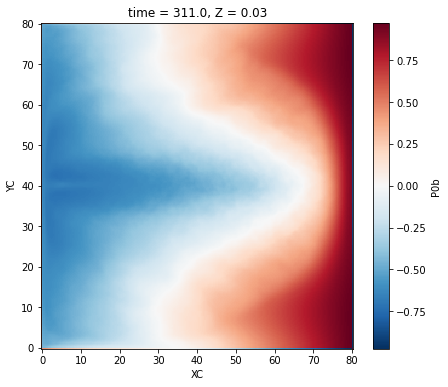

In [6]:
dsb.P0b.isel(time=0).plot(figsize=(7,6))

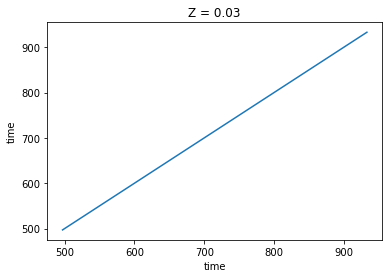

In [6]:
dsb.time.plot()

In [7]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd == 2:
        psi = np.pad(psi,((1,1),(1,1)),'constant')
    elif nd == 3:
        psi = qgutils.pad_bc(psi)
    elif nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi

In [ ]:
P0 = pad_bc(dsb.P0b)
P1 = pad_bc(dsb.P1b)
P2 = pad_bc(dsb.P2b)
P3 = pad_bc(dsb.P3b) 

In [24]:
P0x = np.diff(P0[...,1:-1,:], axis=-1) / DX
P0x = xr.DataArray(.5*(P0x[...,1:] + P0x[...,:-1]), dims=dsb.P0b.dims, coords=dsb.P0b.coords
                  )
P0y = np.diff(P0[...,1:-1], axis=-2) / DX
P0y = xr.DataArray(.5*(P0y[...,1:,:] + P0y[...,:-1,:]), dims=dsb.P0b.dims, coords=dsb.P0b.coords
                  )

    
P1x = np.diff(P1[...,1:-1,:], axis=-1) / DX
P1x = xr.DataArray(.5*(P1x[...,1:] + P1x[...,:-1]), dims=dsb.P1b.dims, coords=dsb.P1b.coords
                  )
P1y = np.diff(P1[...,1:-1], axis=-2) / DX
P1y = xr.DataArray(.5*(P1y[...,1:,:] + P1y[...,:-1,:]), dims=dsb.P1b.dims, coords=dsb.P1b.coords
                  )

    
P2x = np.diff(P2[...,1:-1,:], axis=-1) / DX
P2x = xr.DataArray(.5*(P2x[...,1:] + P2x[...,:-1]), dims=dsb.P2b.dims, coords=dsb.P2b.coords
                  )
P2y = np.diff(P2[...,1:-1], axis=-2) / DX
P2y = xr.DataArray(.5*(P2y[...,1:,:] + P2y[...,:-1,:]), dims=dsb.P2b.dims, coords=dsb.P2b.coords
                  )

   
P3x = np.diff(P3[...,1:-1,:], axis=-1) / DX
P3x = xr.DataArray(.5*(P3x[...,1:] + P3x[...,:-1]), dims=dsb.P3b.dims, coords=dsb.P3b.coords
                  )
P3y = np.diff(P3[...,1:-1], axis=-2) / DX
P3y = xr.DataArray(.5*(P3y[...,1:,:] + P3y[...,:-1,:]), dims=dsb.P3b.dims, coords=dsb.P3b.coords
                  )

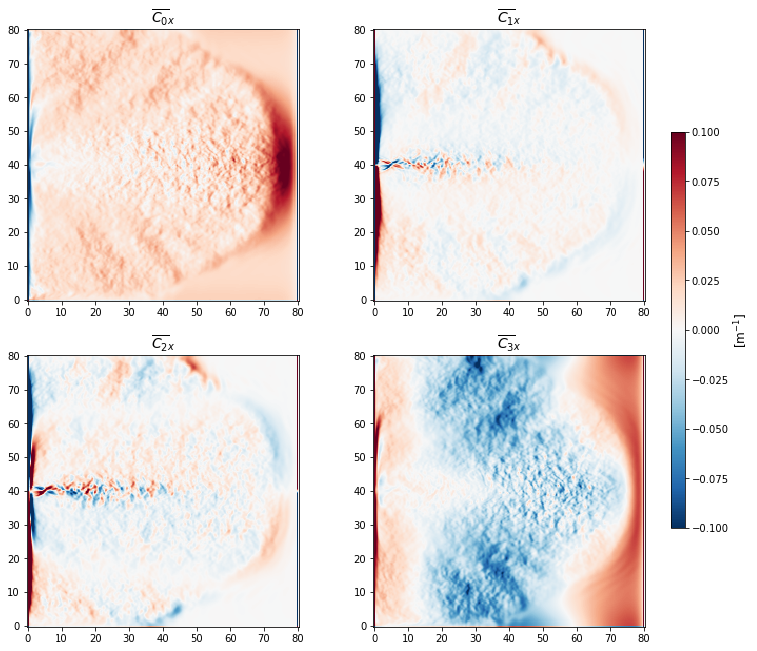

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsb.XC, dsb.YC, P0x.isel(time=0),
                          vmax=.1, vmin=-.1, cmap='RdBu_r', 
                          shading='auto', rasterized=True
                         )
axes[0,1].pcolormesh(dsb.XC, dsb.YC, P1x.isel(time=0),
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
                    )
axes[1,1].pcolormesh(dsb.XC, dsb.YC, P2x.isel(time=0), 
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
    )
axes[1,0].pcolormesh(dsb.XC, dsb.YC, P3x.isel(time=0), 
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
    )
    
axes[0,0].set_title(r"$\overline{C_0}_x$", fontsize=14)
axes[0,1].set_title(r"$\overline{C_1}_x$", fontsize=14)
axes[1,0].set_title(r"$\overline{C_2}_x$", fontsize=14)
axes[1,1].set_title(r"$\overline{C_3}_x$", fontsize=14)
    
axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m$^{-1}$]", fontsize=12)
# plt.savefig(op.join(ddir,'Figs/Ptr2_RFr_cluster-%02d_6yrs_00.pdf' % nGMM))

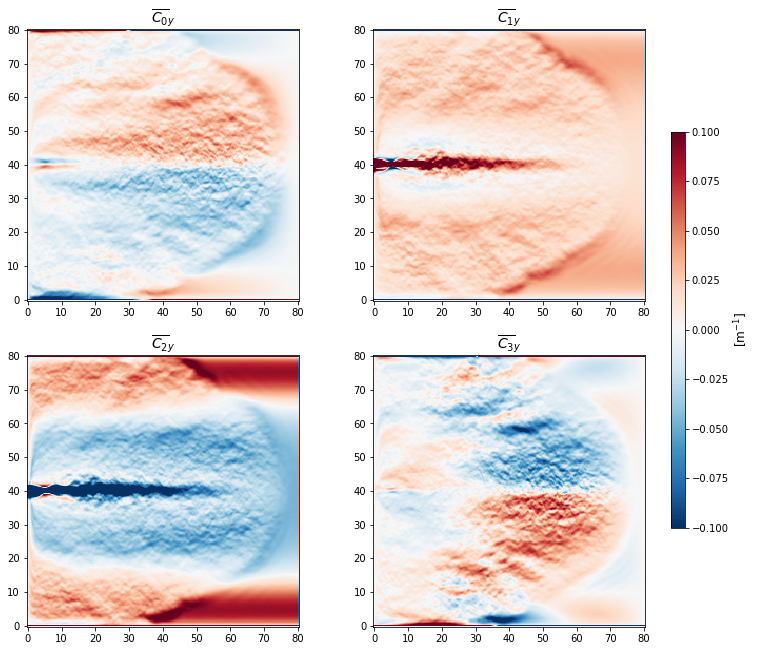

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsb.XC, dsb.YC, P0y.isel(time=0),
                          vmax=.1, vmin=-.1, cmap='RdBu_r', 
                          shading='auto', rasterized=True
                         )
axes[0,1].pcolormesh(dsb.XC, dsb.YC, P1y.isel(time=0),
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
                    )
axes[1,1].pcolormesh(dsb.XC, dsb.YC, P2y.isel(time=0), 
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
    )
axes[1,0].pcolormesh(dsb.XC, dsb.YC, P3y.isel(time=0), 
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
    )
    
axes[0,0].set_title(r"$\overline{C_0}_y$", fontsize=14)
axes[0,1].set_title(r"$\overline{C_1}_y$", fontsize=14)
axes[1,0].set_title(r"$\overline{C_2}_y$", fontsize=14)
axes[1,1].set_title(r"$\overline{C_3}_y$", fontsize=14)
    
axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m$^{-1}$]", fontsize=12)
# plt.savefig(op.join(ddir,'Figs/Ptr2_RFr_cluster-%02d_6yrs_00.pdf' % nGMM))

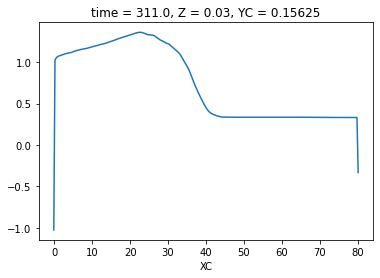

In [13]:
P3y.isel(time=0,YC=1).plot()

In [14]:
dsave = P0y.to_dataset(name='P0y')
dsave['P0x'] = P0x
dsave['P1y'] = P1y
dsave['P1x'] = P1x
dsave['P2y'] = P2y
dsave['P2x'] = P2x
dsave['P3y'] = P3y
dsave['P3x'] = P3x
dsave.P0y.encoding = {}
dsave.P0x.encoding = {}
dsave.P1y.encoding = {}
dsave.P1x.encoding = {}
dsave.P2y.encoding = {}
dsave.P2x.encoding = {}
dsave.P3y.encoding = {}
dsave.P3x.encoding = {}
print(dsave)
dsave.chunk({'time':9,'YC':128,'XC':128}).to_zarr(op.join(ddir,'mPTRgrad.zarr'))
dsave.close()

In [16]:
P0x = np.diff(P0[...,1:-1,:], axis=-1) / DX
P0xx = xr.DataArray(np.diff(P0x, axis=-1) / DX, dims=dsb.P0b.dims, coords=dsb.P0b.coords
                   )
P0y = np.diff(P0[...,1:-1], axis=-2) / DX
P0yy = xr.DataArray(np.diff(P0y, axis=-2) / DX, dims=dsb.P0b.dims, coords=dsb.P0b.coords
                   )

P1x = np.diff(P1[...,1:-1,:], axis=-1) / DX
P1xx = xr.DataArray(np.diff(P1x, axis=-1) / DX, dims=dsb.P1b.dims, coords=dsb.P1b.coords
                   )
P1y = np.diff(P1[...,1:-1], axis=-2) / DX
P1yy = xr.DataArray(np.diff(P1y, axis=-2) / DX, dims=dsb.P1b.dims, coords=dsb.P1b.coords
                   )
 
P2x = np.diff(P2[...,1:-1,:], axis=-1) / DX
P2xx = xr.DataArray(np.diff(P2x, axis=-1) / DX, dims=dsb.P2b.dims, coords=dsb.P2b.coords
                   )
P2y = np.diff(P2[...,1:-1], axis=-2) / DX
P2yy = xr.DataArray(np.diff(P2y, axis=-2) / DX, dims=dsb.P2b.dims, coords=dsb.P2b.coords
                   )
    
P3x = np.diff(P3[...,1:-1,:], axis=-1) / DX
P3xx = xr.DataArray(np.diff(P3x, axis=-1) / DX, dims=dsb.P3b.dims, coords=dsb.P3b.coords
                   )
P3y = np.diff(P3[...,1:-1], axis=-2) / DX
P3yy = xr.DataArray(np.diff(P3y, axis=-2) / DX, dims=dsb.P3b.dims, coords=dsb.P3b.coords
                   )

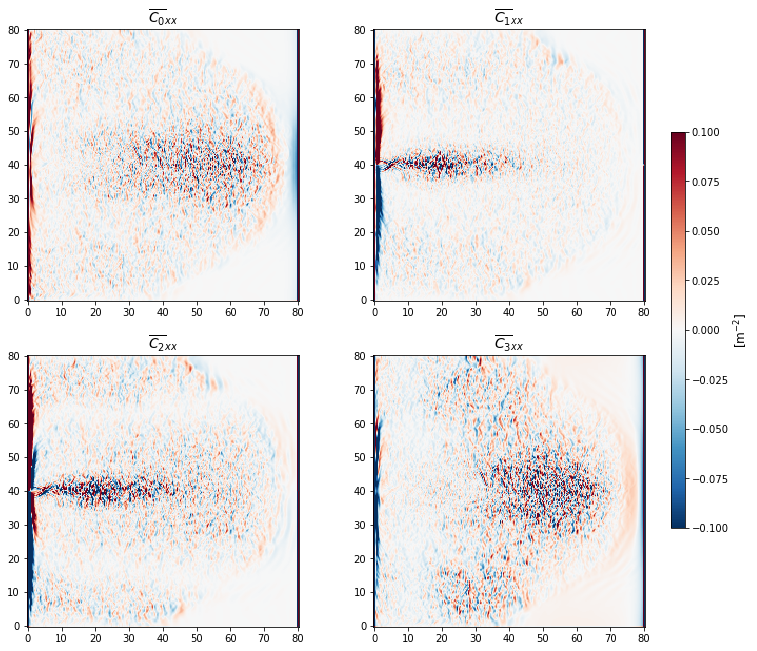

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsb.XC, dsb.YC, P0xx.isel(time=0),
                          vmax=.1, vmin=-.1, cmap='RdBu_r', 
                          shading='auto', rasterized=True
                         )
axes[0,1].pcolormesh(dsb.XC, dsb.YC, P1xx.isel(time=0),
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
                    )
axes[1,1].pcolormesh(dsb.XC, dsb.YC, P2xx.isel(time=0), 
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
    )
axes[1,0].pcolormesh(dsb.XC, dsb.YC, P3xx.isel(time=0), 
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
    )
    
axes[0,0].set_title(r"$\overline{C_0}_{xx}$", fontsize=14)
axes[0,1].set_title(r"$\overline{C_1}_{xx}$", fontsize=14)
axes[1,0].set_title(r"$\overline{C_2}_{xx}$", fontsize=14)
axes[1,1].set_title(r"$\overline{C_3}_{xx}$", fontsize=14)
    
axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m$^{-2}$]", fontsize=12)
# plt.savefig(op.join(ddir,'Figs/Ptr2_RFr_cluster-%02d_6yrs_00.pdf' % nGMM))

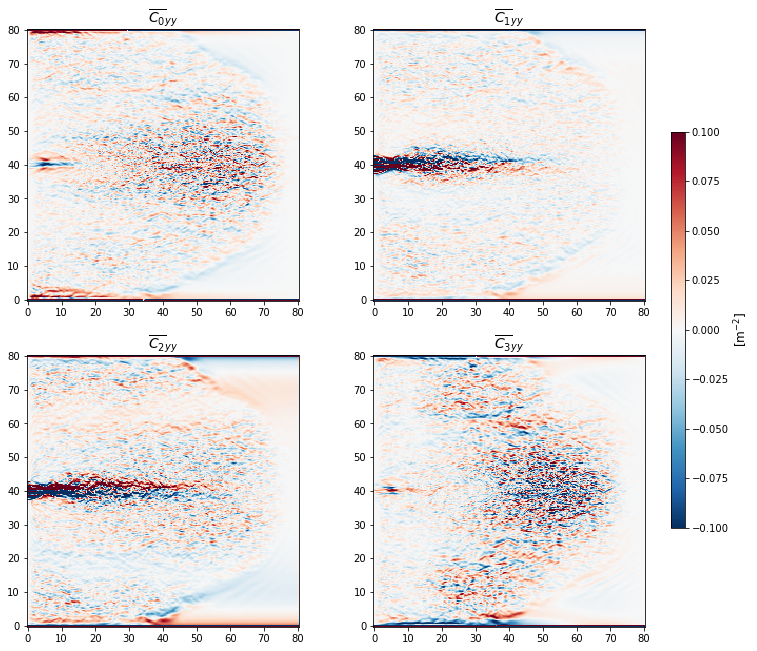

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsb.XC, dsb.YC, P0yy.isel(time=0),
                          vmax=.1, vmin=-.1, cmap='RdBu_r', 
                          shading='auto', rasterized=True
                         )
axes[0,1].pcolormesh(dsb.XC, dsb.YC, P1yy.isel(time=0),
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
                    )
axes[1,1].pcolormesh(dsb.XC, dsb.YC, P2yy.isel(time=0), 
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
    )
axes[1,0].pcolormesh(dsb.XC, dsb.YC, P3yy.isel(time=0), 
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True
    )
    
axes[0,0].set_title(r"$\overline{C_0}_{yy}$", fontsize=14)
axes[0,1].set_title(r"$\overline{C_1}_{yy}$", fontsize=14)
axes[1,0].set_title(r"$\overline{C_2}_{yy}$", fontsize=14)
axes[1,1].set_title(r"$\overline{C_3}_{yy}$", fontsize=14)
    
axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m$^{-2}$]", fontsize=12)
# plt.savefig(op.join(ddir,'Figs/Ptr2_RFr_cluster-%02d_6yrs_00.pdf' % nGMM))

In [20]:
dsave = P0yy.to_dataset(name='P0yy')
dsave['P0xx'] = P0xx
dsave['P1yy'] = P1yy
dsave['P1xx'] = P1xx
dsave['P2yy'] = P2yy
dsave['P2xx'] = P2xx
dsave['P3yy'] = P3yy
dsave['P3xx'] = P3xx
dsave.P0yy.encoding = {}
dsave.P0xx.encoding = {}
dsave.P1yy.encoding = {}
dsave.P1xx.encoding = {}
dsave.P2yy.encoding = {}
dsave.P2xx.encoding = {}
dsave.P3yy.encoding = {}
dsave.P3xx.encoding = {}
print(dsave)
dsave.chunk({'time':9,'YC':128,'XC':128}).to_zarr(op.join(ddir,'mPTRgrad2.zarr'))
dsave.close()

<xarray.Dataset>
Dimensions:  (XC: 258, YC: 258, time: 624)
Coordinates:
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 930.0 931.0 932.0 933.0
    Z        float64 0.03
  * YC       (YC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
  * XC       (XC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
Data variables:
    P0yy     (time, YC, XC) float32 18.88 -18.88 -18.39 ... 39.72 39.78 -39.78
    P0xx     (time, YC, XC) float32 18.88 -9.565 0.02962 ... 19.91 -39.78
    P1yy     (time, YC, XC) float32 35.67 -35.67 -35.54 ... 39.62 39.62 -39.62
    P1xx     (time, YC, XC) float32 35.67 -17.87 0.01266 ... 19.81 -39.62
    P2yy     (time, YC, XC) float32 -19.44 19.44 19.83 ... -3.877 -3.668 3.668
    P2xx     (time, YC, XC) float32 -19.44 9.619 0.03604 ... -1.782 3.668
    P3yy     (time, YC, XC) float32 -13.13 13.13 13.41 ... -4.133 -4.133 4.133
    P3xx     (time, YC, XC) float32 -13.13 6.493 0.02891 ... -2.066 4.133
